In [2]:
import pandas as pd

csv_file_path = "/content/BenignAndMaliciousDataset (1).csv"
df=pd.read_csv(csv_file_path)
df

,Domain,DNSRecordType,MXDnsResponse,TXTDnsResponse,HasSPFInfo,HasDkimInfo,HasDmarcInfo,Ip,DomainInAlexaDB,CommonPorts,...,ConsoantRatio,NumericRatio,SpecialCharRatio,VowelRatio,ConsoantSequence,VowelSequence,NumericSequence,SpecialCharSequence,DomainLength,Class
0,4455,A,False,False,False,False,False,16984,False,False,...,0.6,0.1,0.0,0.2,10,4,1,0,134,1
1,4456,A,False,False,False,False,False,16984,False,False,...,0.7,0.1,0.0,0.2,12,2,2,1,123,1
2,4457,A,False,False,False,False,False,16984,False,False,...,0.6,0.2,0.0,0.2,16,2,3,0,150,1
3,4458,A,False,False,False,False,False,16984,False,False,...,0.6,0.1,0.0,0.1,9,1,2,0,122,1
4,4459,A,False,False,False,False,False,16984,False,False,...,0.6,0.2,0.0,0.1,10,2,2,0,151,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,75661,A,False,False,False,False,False,16984,False,False,...,0.5,0.2,0.0,0.2,4,1,2,0,27,0
89996,54843,A,False,False,False,False,False,16984,False,False,...,0.6,0.0,0.0,0.4,3,2,0,0,26,0
89997,71235,A,False,False,False,False,False,16984,False,False,...,0.5,0.1,0.0,0.4,3,2,2,0,31,0
89998,82994,A,True,True,True,False,False,7723,False,False,...,0.5,0.0,0.0,0.4,4,2,0,0,11,0


In [ ]:
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw
import os
from collections import Counter

def dns_to_image_conversion_stripes(csv_file_path, output_dir, image_size=224):
    """
    Convert DNS CSV data to images using clear stripe patterns.
    Saves images into subfolders based on class and reports dataset balance.

    Args:
        csv_file_path: Path to the DNS CSV file.
        output_dir: Directory to save the generated images.
        image_size: Size of the generated square image (default 224x224).
    """


    os.makedirs(output_dir, exist_ok=True)
    try:
        df = pd.read_csv(csv_file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {csv_file_path}.")
        return


    drop_cols = [
        "Domain", "Ip", "DomainInAlexaDB", "CountryCode", "RegisteredCountry",
        "CreationDate", "LastUpdateDate", "ASN", "HttpResponseCode",
        "RegisteredOrg"
    ]
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])


    label_map = {0: "malicious", 1: "non_malicious"}
    df["label_name"] = df["Class"].map(label_map)

    feature_columns = [
        "MXDnsResponse", "TXTDnsResponse", "HasSPFInfo", "HasDkimInfo", "HasDmarcInfo",
        "CommonPorts", "IpReputation", "DomainReputation", "SubdomainNumber",
        "Entropy", "EntropyOfSubDomains", "StrangeCharacters", "TLD",
        "ConsoantRatio", "VowelRatio", "NumericRatio", "SpecialCharRatio",
        "ConsoantSequence", "VowelSequence", "NumericSequence", "SpecialCharSequence",
        "DomainLength"
    ]

    feature_columns = [c for c in feature_columns if c in df.columns]

    if len(feature_columns) == 0:
        print("No valid feature columns found. Exiting.")
        return


    numeric_features = df[feature_columns].select_dtypes(include=np.number).columns
    feature_min_max = {
        feature: (df[feature].min(), df[feature].max()) for feature in numeric_features
    }

    def get_intensity(feature_name, value):
        if pd.isna(value):
            return 0
        if feature_name in numeric_features:
            min_val, max_val = feature_min_max[feature_name]
            if max_val == min_val:
                return 128
            return int(255 * (value - min_val) / (max_val - min_val))
        else:
            
            return abs(hash(str(value))) % 256


    print("Starting image generation...")
    class_counts = Counter()

    for idx, row in df.iterrows():
        label = row["label_name"]
        class_counts[label] += 1

        class_folder = os.path.join(output_dir, label)
        os.makedirs(class_folder, exist_ok=True)

        image = Image.new("L", (image_size, image_size), 0)
        draw = ImageDraw.Draw(image)

        stripe_height = image_size / len(feature_columns)
        for i, feature_name in enumerate(feature_columns):
            value = row[feature_name]
            intensity = get_intensity(feature_name, value)
            y_start = int(i * stripe_height)
            y_end = int((i + 1) * stripe_height)
            draw.rectangle([0, y_start, image_size, y_end], fill=intensity)

        rgb_image = image.convert("RGB")
        image_filename = f"{label}_{idx}.png"
        rgb_image.save(os.path.join(class_folder, image_filename))

        if (idx + 1) % 1000 == 0:
            print(f"Processed {idx + 1} records...")

    print(f"Image generation complete. Images are saved in '{output_dir}'.")

    print("\nClass distribution:")
    for cls, count in class_counts.items():
        print(f"{cls}: {count} images")

    min_count = min(class_counts.values())
    max_count = max(class_counts.values())
    if min_count / max_count > 0.8:
        print("Dataset is roughly balanced")
    else:
        print("Dataset is imbalanced")


dns_to_image_conversion_stripes(
    csv_file_path=csv_file_path,
    output_dir="dns_images_stripes_by_class"
)


Starting image generation...
Processed 1000 records...
Processed 2000 records...
Processed 3000 records...
Processed 4000 records...
Processed 5000 records...
Processed 6000 records...
Processed 7000 records...
Processed 8000 records...
Processed 9000 records...
Processed 10000 records...
Processed 11000 records...
Processed 12000 records...
Processed 13000 records...
Processed 14000 records...
Processed 15000 records...
Processed 16000 records...
Processed 17000 records...
Processed 18000 records...
Processed 19000 records...
Processed 20000 records...
Processed 21000 records...
Processed 22000 records...
Processed 23000 records...
Processed 24000 records...
Processed 25000 records...
Processed 26000 records...
Processed 27000 records...
Processed 28000 records...
Processed 29000 records...
Processed 30000 records...
Processed 31000 records...
Processed 32000 records...
Processed 33000 records...
Processed 34000 records...
Processed 35000 records...
Processed 36000 records...
Processe

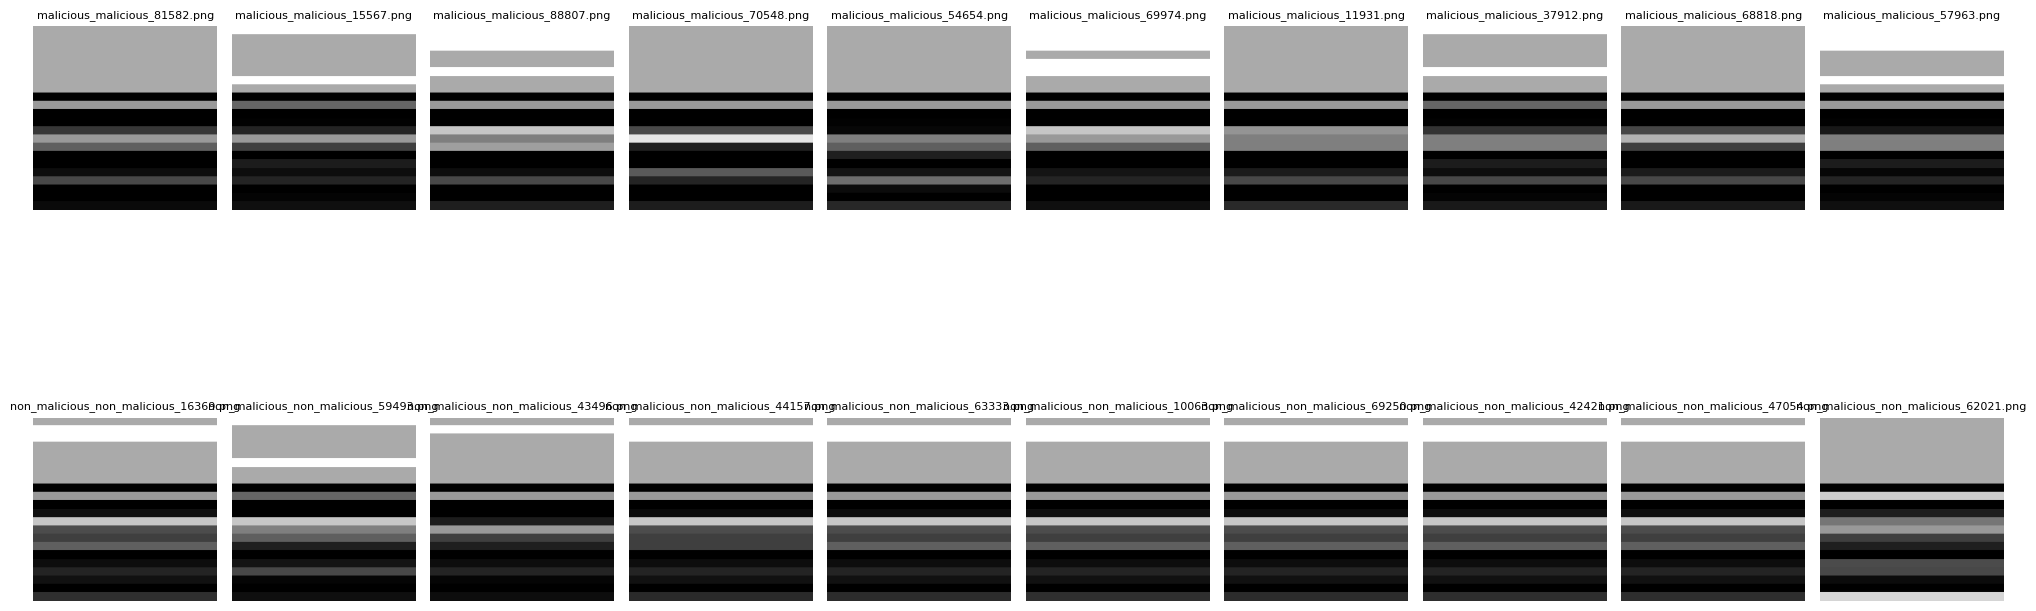

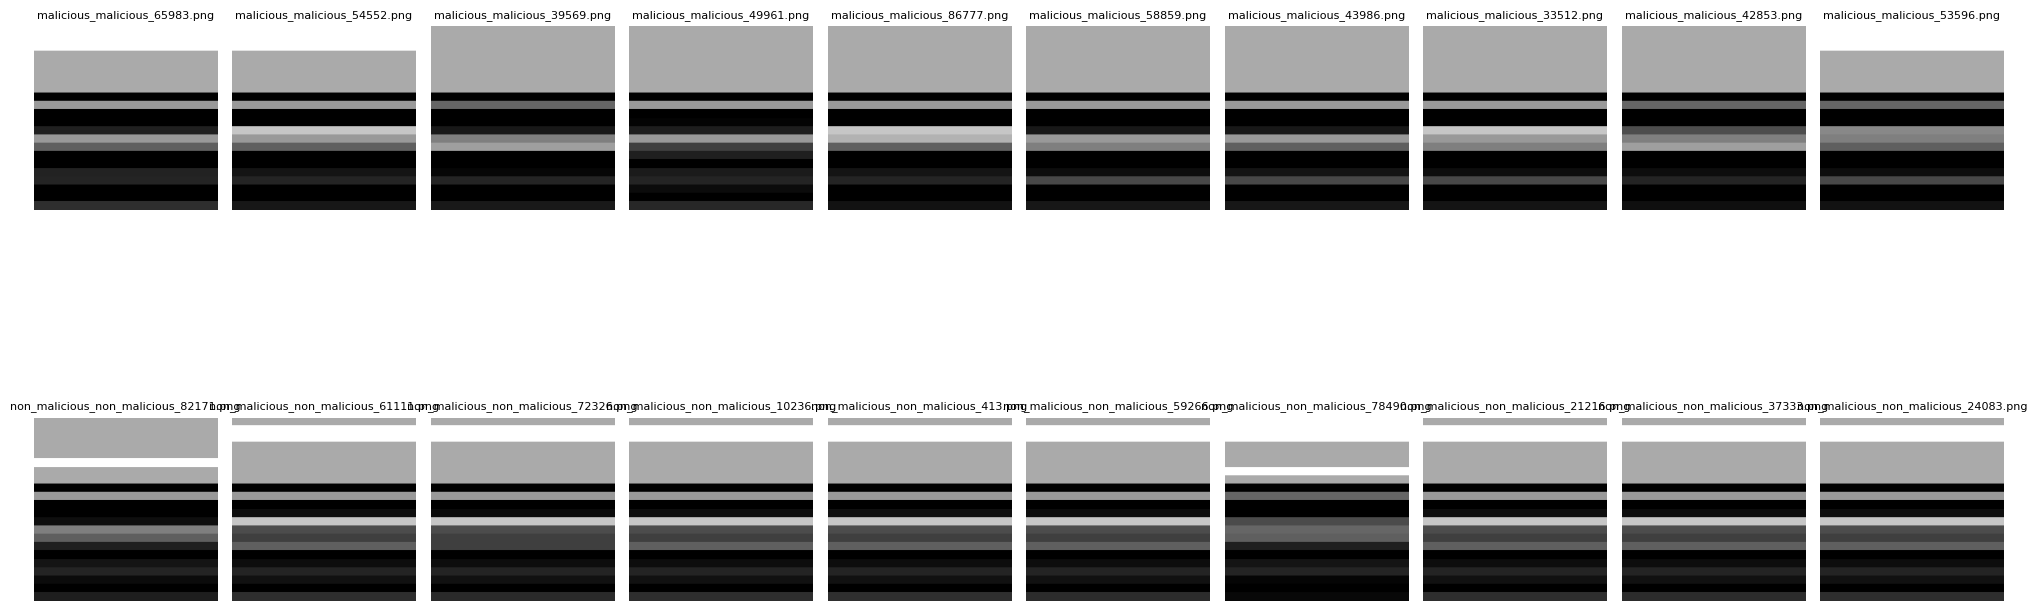

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import random

base_folder = "/content/dns_images_stripes_by_class"

classes = ['malicious', 'non_malicious']  

num_samples = 10

plt.figure(figsize=(20, 5 * len(classes)))

for row_idx, cls in enumerate(classes):
    class_folder = os.path.join(base_folder, cls)
    if not os.path.exists(class_folder):
        print(f"Class folder '{class_folder}' does not exist!")
        continue

    image_files = os.listdir(class_folder)
    if len(image_files) < num_samples:
        sampled_files = image_files
    else:
        sampled_files = random.sample(image_files, num_samples)

    for col_idx, fname in enumerate(sampled_files):
        img = Image.open(os.path.join(class_folder, fname))
        plt_idx = row_idx * num_samples + col_idx + 1
        plt.subplot(len(classes), num_samples, plt_idx)
        plt.imshow(img)
        plt.title(f"{cls}_{fname}", fontsize=8)
        plt.axis("off")

plt.tight_layout()
plt.show()


In [8]:
# MODEL TRAINING
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# --- Configuration ---
data_dir = "/content/dns_images_stripes_by_class" 
batch_size = 32
num_epochs = 20
image_size = 224
num_classes = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
print("Classes:", dataset.classes)
total_len = len(dataset)
print(f"Total samples: {total_len}")

indices = list(range(total_len))
labels = [dataset.targets[i] for i in indices]

train_idx, test_idx = train_test_split(
    indices, test_size=0.2, stratify=labels, random_state=42
)

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Classes: ['malicious', 'non_malicious']
Total samples: 90000
Train samples: 72000
Test samples: 18000


In [12]:
class DNSCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(DNSCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 224 -> 112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112 -> 56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56 -> 28

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28 -> 14
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*14*14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = DNSCNN(num_classes=num_classes).to(device)
print(model)


DNSCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

best_train_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")


    if train_acc > best_train_acc:
        best_train_acc = train_acc
        torch.save(model.state_dict(), "model.pth")
        print(f"Saved best model with Train Acc: {best_train_acc:.2f}%")

print(f"Training complete. Best training accuracy: {best_train_acc:.2f}%")

Epoch 1/20 - Training: 100%|██████████| 2250/2250 [04:56<00:00,  7.59it/s]


Epoch [1/20] Train Loss: 0.1059, Train Acc: 95.73%
Saved best model with Train Acc: 95.73%


Epoch 2/20 - Training: 100%|██████████| 2250/2250 [04:54<00:00,  7.63it/s]


Epoch [2/20] Train Loss: 0.0828, Train Acc: 96.53%
Saved best model with Train Acc: 96.53%


Epoch 3/20 - Training: 100%|██████████| 2250/2250 [04:53<00:00,  7.66it/s]


Epoch [3/20] Train Loss: 0.0742, Train Acc: 96.79%
Saved best model with Train Acc: 96.79%


Epoch 4/20 - Training: 100%|██████████| 2250/2250 [04:53<00:00,  7.68it/s]


Epoch [4/20] Train Loss: 0.0706, Train Acc: 96.87%
Saved best model with Train Acc: 96.87%


Epoch 5/20 - Training: 100%|██████████| 2250/2250 [04:52<00:00,  7.69it/s]


Epoch [5/20] Train Loss: 0.0676, Train Acc: 97.00%
Saved best model with Train Acc: 97.00%


Epoch 6/20 - Training: 100%|██████████| 2250/2250 [04:49<00:00,  7.76it/s]


Epoch [6/20] Train Loss: 0.0667, Train Acc: 97.11%
Saved best model with Train Acc: 97.11%


Epoch 7/20 - Training: 100%|██████████| 2250/2250 [04:49<00:00,  7.78it/s]


Epoch [7/20] Train Loss: 0.0642, Train Acc: 97.13%
Saved best model with Train Acc: 97.13%


Epoch 8/20 - Training: 100%|██████████| 2250/2250 [04:48<00:00,  7.79it/s]


Epoch [8/20] Train Loss: 0.0643, Train Acc: 97.22%
Saved best model with Train Acc: 97.22%


Epoch 9/20 - Training: 100%|██████████| 2250/2250 [04:49<00:00,  7.77it/s]


Epoch [9/20] Train Loss: 0.0630, Train Acc: 97.28%
Saved best model with Train Acc: 97.28%


Epoch 10/20 - Training: 100%|██████████| 2250/2250 [04:48<00:00,  7.79it/s]


Epoch [10/20] Train Loss: 0.0618, Train Acc: 97.33%
Saved best model with Train Acc: 97.33%


Epoch 11/20 - Training: 100%|██████████| 2250/2250 [04:49<00:00,  7.78it/s]


Epoch [11/20] Train Loss: 0.0612, Train Acc: 97.36%
Saved best model with Train Acc: 97.36%


Epoch 12/20 - Training: 100%|██████████| 2250/2250 [04:50<00:00,  7.74it/s]


Epoch [12/20] Train Loss: 0.0605, Train Acc: 97.40%
Saved best model with Train Acc: 97.40%


Epoch 13/20 - Training: 100%|██████████| 2250/2250 [04:49<00:00,  7.76it/s]


Epoch [13/20] Train Loss: 0.0590, Train Acc: 97.41%
Saved best model with Train Acc: 97.41%


Epoch 14/20 - Training: 100%|██████████| 2250/2250 [04:50<00:00,  7.75it/s]


Epoch [14/20] Train Loss: 0.0579, Train Acc: 97.51%
Saved best model with Train Acc: 97.51%


Epoch 15/20 - Training: 100%|██████████| 2250/2250 [04:52<00:00,  7.68it/s]


Epoch [15/20] Train Loss: 0.0579, Train Acc: 97.49%


Epoch 16/20 - Training: 100%|██████████| 2250/2250 [04:49<00:00,  7.77it/s]


Epoch [16/20] Train Loss: 0.0571, Train Acc: 97.48%


Epoch 17/20 - Training: 100%|██████████| 2250/2250 [04:50<00:00,  7.73it/s]


Epoch [17/20] Train Loss: 0.0574, Train Acc: 97.46%


Epoch 18/20 - Training: 100%|██████████| 2250/2250 [04:51<00:00,  7.72it/s]


Epoch [18/20] Train Loss: 0.0577, Train Acc: 97.55%
Saved best model with Train Acc: 97.55%


Epoch 19/20 - Training: 100%|██████████| 2250/2250 [04:51<00:00,  7.73it/s]


Epoch [19/20] Train Loss: 0.0557, Train Acc: 97.58%
Saved best model with Train Acc: 97.58%


Epoch 20/20 - Training: 100%|██████████| 2250/2250 [04:51<00:00,  7.72it/s]

Epoch [20/20] Train Loss: 0.0557, Train Acc: 97.57%
Training complete. Best training accuracy: 97.58%


Test Accuracy: 97.77%


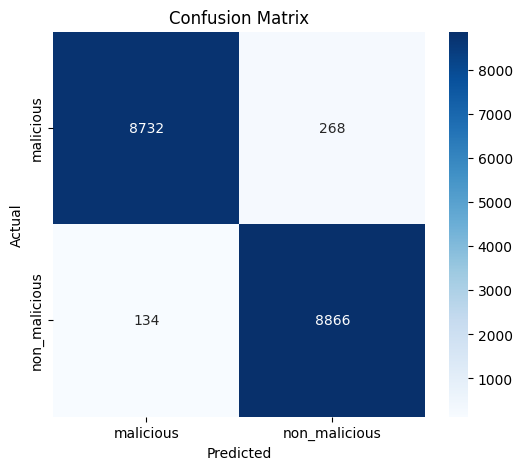


Classification Report:
               precision    recall  f1-score   support

    malicious       0.98      0.97      0.98      9000
non_malicious       0.97      0.99      0.98      9000

     accuracy                           0.98     18000
    macro avg       0.98      0.98      0.98     18000
 weighted avg       0.98      0.98      0.98     18000



In [ ]:
import torch
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


model.load_state_dict(torch.load("model.pth"))
model.eval()
model.to(device)


all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:  
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy*100:.2f}%")


cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))


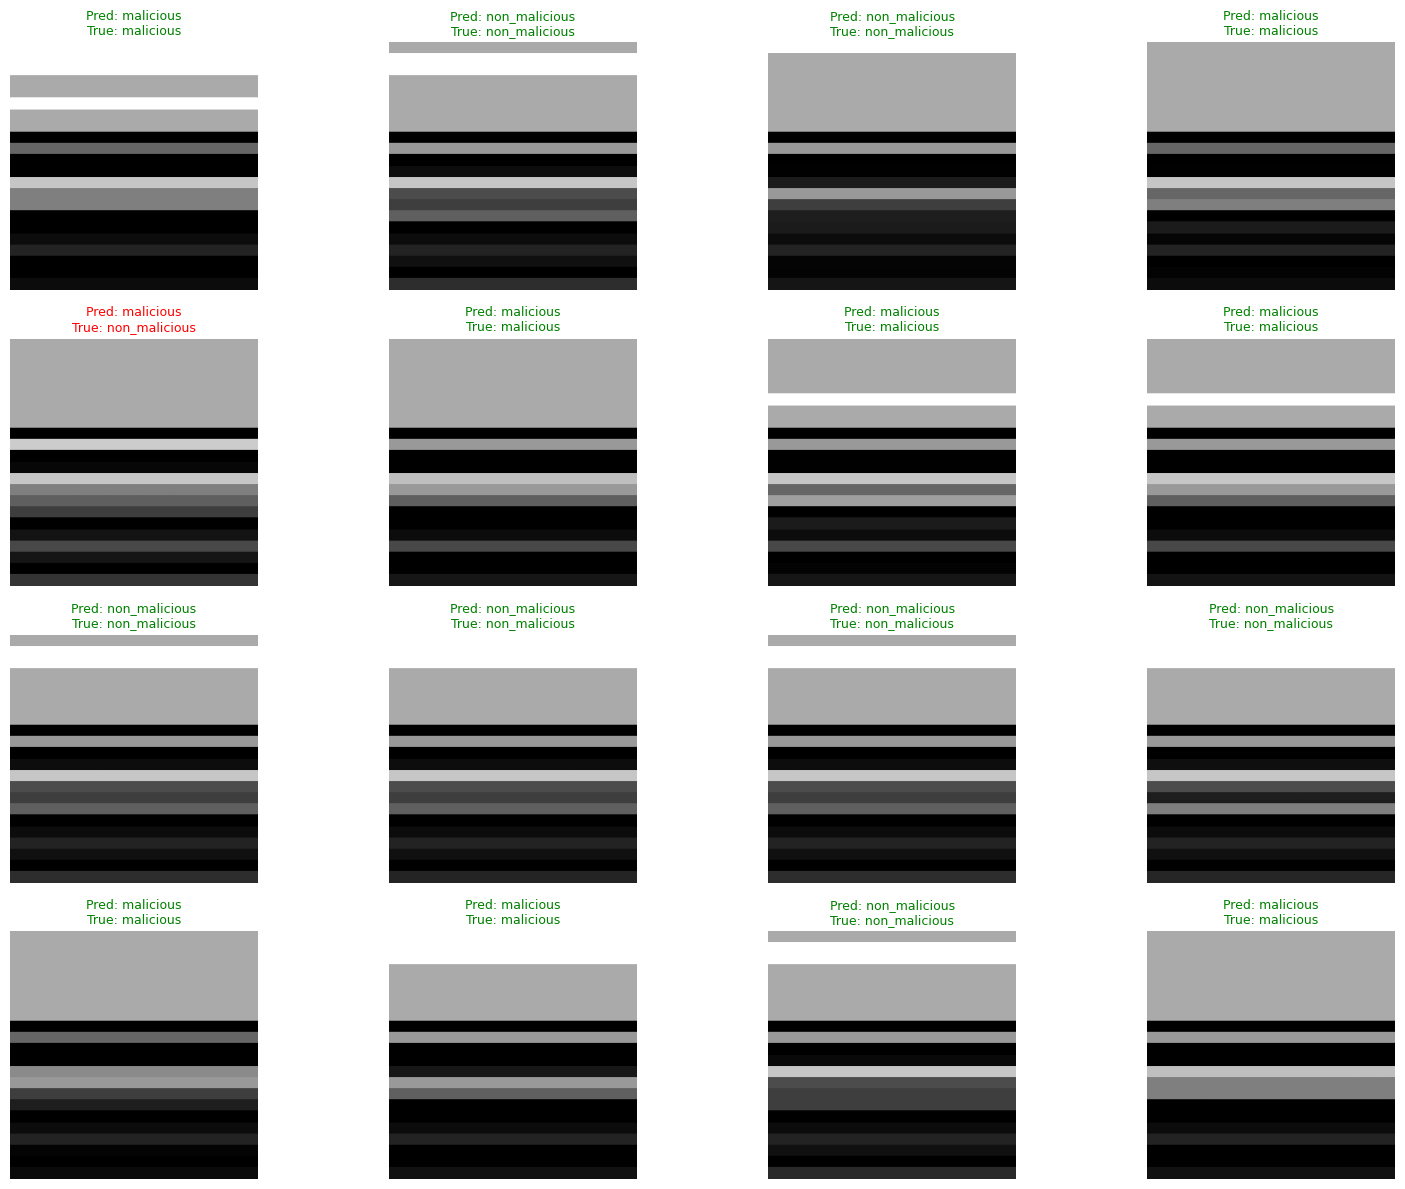

In [ ]:
import random
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

model.eval()

num_samples = 16   
indices = random.sample(range(len(test_dataset)), num_samples)

plt.figure(figsize=(16, 12))  

for i, idx in enumerate(indices):
    img, label = test_dataset[idx]
    img_input = img.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_input)
        _, pred = torch.max(output, 1)

    pred_label = dataset.classes[pred.item()]
    true_label = dataset.classes[label]

    img_show = img.permute(1, 2, 0).cpu().numpy()
    img_show = (img_show * 0.5 + 0.5).clip(0, 1)  

    plt.subplot(4, 4, i+1)
    plt.imshow(img_show)

    color = "green" if pred_label == true_label else "red"
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color, fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


Total misclassified samples: 402


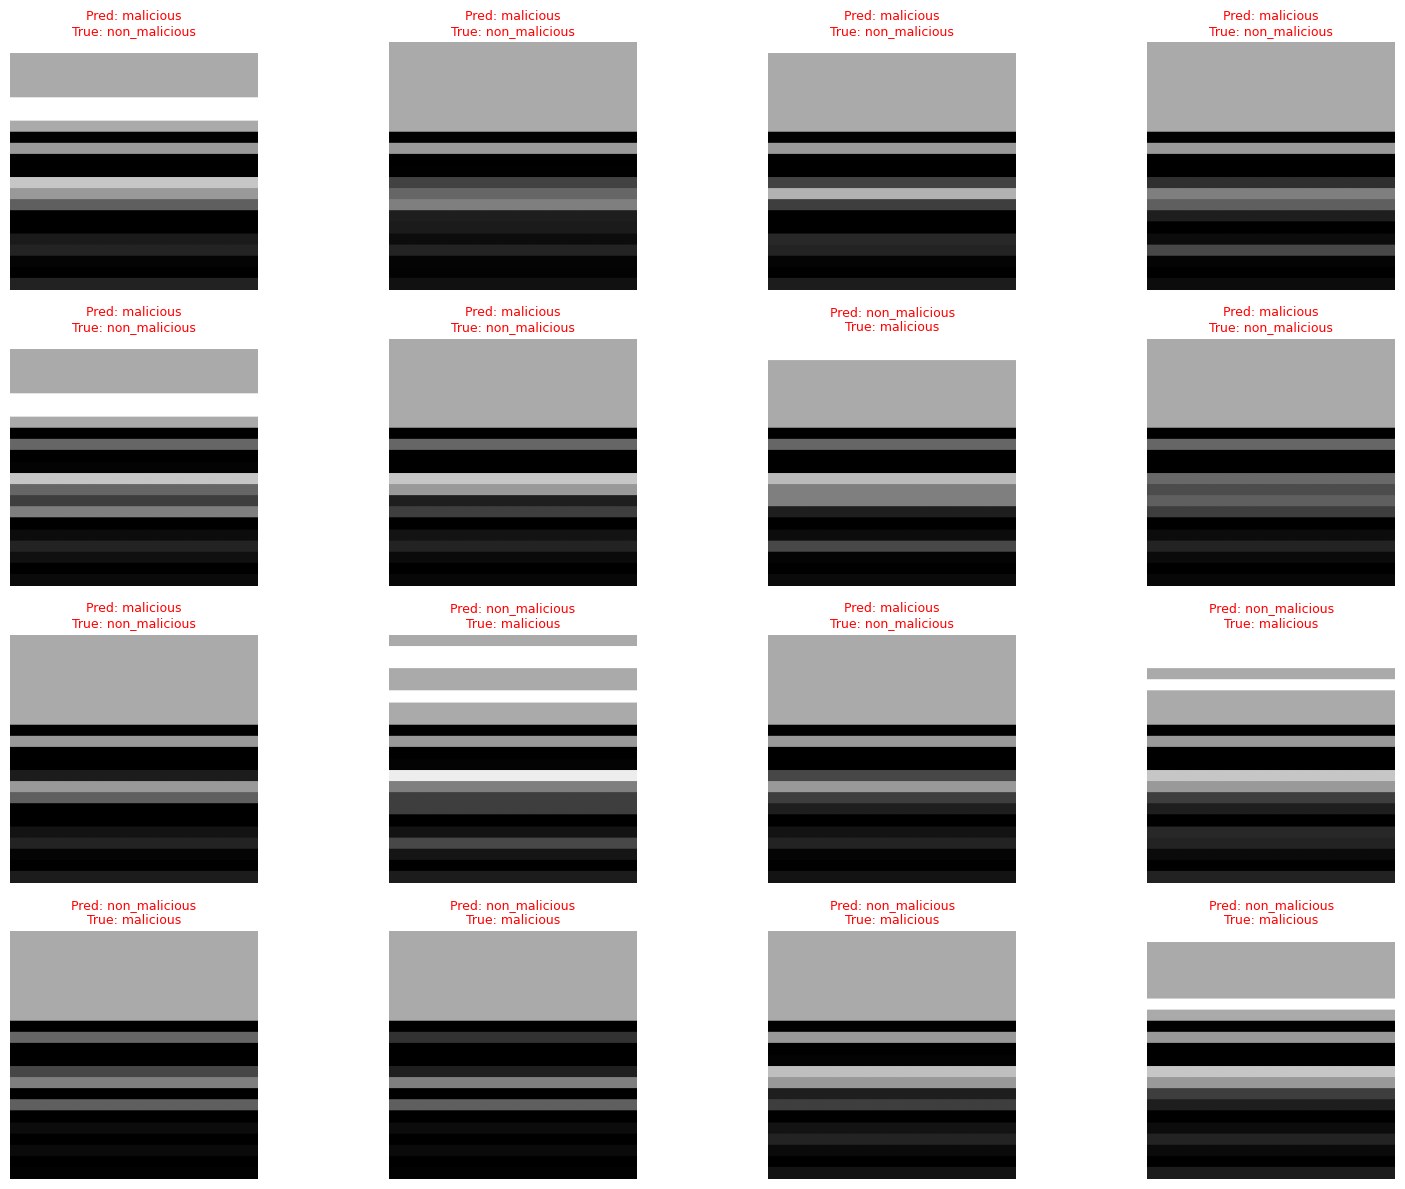

In [ ]:
#Misclassified Samples

import matplotlib.pyplot as plt


wrong_images = []
wrong_preds = []
wrong_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for i in range(len(labels)):
            if preds[i] != labels[i]:
                wrong_images.append(images[i].cpu())
                wrong_preds.append(preds[i].cpu())
                wrong_labels.append(labels[i].cpu())

print(f"Total misclassified samples: {len(wrong_images)}")


num_show = min(16, len(wrong_images))  
plt.figure(figsize=(16, 12))

for i in range(num_show):
    img = wrong_images[i]
    pred = wrong_preds[i].item()
    true = wrong_labels[i].item()

    img_show = img.permute(1, 2, 0).numpy()
    img_show = (img_show * 0.5 + 0.5).clip(0, 1)  

    plt.subplot(4, 4, i + 1)
    plt.imshow(img_show)
    plt.title(f"Pred: {dataset.classes[pred]}\nTrue: {dataset.classes[true]}",
              fontsize=9, color="red")
    plt.axis("off")

plt.tight_layout()
plt.show()
